# Part 1: Network Training

## Step0: Import Package & Hyperparameter Configuration

In [104]:
# 清空所有變數
%reset -f  
# 強制 Python 回收記憶體
import gc
gc.collect()  

0


### Package


In [ ]:
import 

import torch
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

### Hyperparameter Config

In [106]:
# %%
# Unified Hyperparameter Configuration
class Config:
    SEED = 1
    NUM_EPOCHS = 3000
    BATCH_SIZE = 128
    LEARNING_RATE = 0.002  #論文提供
    LR_SCHEDULER_GAMMA = 0.99  #論文提供
    DECAY_EPOCH = 200
    DECAY_RATIO = 0.5
    EARLY_STOPPING_PATIENCE = 500
    HIDDEN_SIZE = 30
    OPERATOR_SIZE = 30


# Reproducibility
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Material & Number of Data

In [107]:
material = "CH467160_Buck"
down_sample_way = "linspace_n_init2"
downsample = 1024
save_figure = False

# 訓練情況況
plot_interval = 300
train_show_sample = 1

# 定義保存模型的路徑
model_save_dir = f"./Model/{down_sample_way}/{downsample}/"
os.makedirs(model_save_dir, exist_ok=True)  # 如果路徑不存在，創建路徑
model_save_path = os.path.join(model_save_dir,
                               f"{material}_n_init2.pt")  # 定義模型保存檔名

figure_save_base_path = f"./figure/{down_sample_way}/{downsample}/"
os.makedirs(figure_save_base_path, exist_ok=True)  # 如果路徑不存在，創建路徑

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step1: Data processing and data loader generate 

In [108]:
# %% Preprocess data into a data loader
def get_dataloader(data_B,
                   data_F,
                   data_T,
                   data_H,
                   data_N,
                   data_Hdc,
                   data_Pcv,
                   n_init=16):

    # Data pre-process

    # ── 0. 全域設定/降階設定 ──────────────────────────────
    eps = 1e-8  # 防止除以 0
    if downsample == 1024:
        seq_length = 1024  # 單筆波形點數 (不再 down-sample)
    else:
        seq_length = downsample
        cols = np.linspace(0, 1023, seq_length, dtype=int)
        data_B = data_B[:, cols]
        data_H = data_H[:, cols]

    # ── 1. 波形拼接 (補 n_init 點作初始磁化) ────
    data_length = seq_length + n_init
    data_B = np.hstack((data_B[:, -n_init:], data_B))  # (batch, data_length)
    data_H = np.hstack((data_H[:, -n_init:], data_H))

    # ── 2. 轉成 Tensor ───────────────────────────
    B = torch.from_numpy(data_B).view(-1, data_length, 1).float()  # (B,N,1)
    H = torch.from_numpy(data_H).view(-1, data_length, 1).float()
    F = torch.log10(torch.from_numpy(data_F).view(-1, 1).float())  # 純量
    T = torch.from_numpy(data_T).view(-1, 1).float()
    Hdc = torch.from_numpy(data_Hdc).view(-1, 1).float()
    N = torch.from_numpy(data_N).view(-1, 1).float()
    Pcv = torch.log10(torch.from_numpy(data_Pcv).view(-1, 1).float())

    # ── 3. 每筆樣本各自找最大幅值 (per-profile scale) ─
    scale_B = torch.max(torch.abs(B), dim=1,
                        keepdim=True).values + eps  # (B,1,1)
    scale_H = torch.max(torch.abs(H), dim=1, keepdim=True).values + eps

    # ── 4. 先計算導數，再除以 scale_B ─────────────
    dB = torch.diff(B, dim=1, prepend=B[:, :1])
    dB_dt = dB * (seq_length * F.view(-1, 1, 1))  # 真實斜率
    d2B = torch.diff(dB, dim=1, prepend=dB[:, :1])
    d2B_dt = d2B * (seq_length * F.view(-1, 1, 1))

    # ── 5. 形成模型輸入 (已經縮放到 [-1,1]) ────────
    in_B = B / scale_B
    out_H = H / scale_H  # 預測目標
    in_dB_dt = dB_dt / scale_B
    in_d2B_dt = d2B_dt / scale_B

    # ── 6. 純量特徵：計算 z-score 參數 ─────────────
    def safe_mean_std(tensor, eps=1e-8):
        m = torch.mean(tensor).item()
        s = torch.std(tensor).item()
        return [m, 1.0 if s < eps else s]

    #  Compute normalization parameters (均值 & 標準差)**
    norm = [
        safe_mean_std(F),
        safe_mean_std(T),
        safe_mean_std(Hdc),
        safe_mean_std(N),
        safe_mean_std(Pcv)
    ]

    # 用來做test固定標準化參數的
    material_name = f"{material}"
    print(f'"{material_name}": [')
    for param in norm:
        print(f"    {param},")
    print("]")
    print("0.F, 1.T, 2.Hdc, 3.N, 4.Pcv")

    # Data Normalization
    in_F = (F - norm[0][0]) / norm[0][1]  # F
    in_T = (T - norm[1][0]) / norm[1][1]  # T
    in_Hdc = (Hdc - norm[2][0]) / norm[2][1]  # Hdc
    in_N = (N - norm[3][0]) / norm[3][1]  # N
    in_Pcv = (Pcv - norm[4][0]) / norm[4][1]  # Pcv

    #   → 方便推論復原，保留 scale_B, scale_H 當作額外純量
    aux_features = torch.cat(
        (in_F, in_T, in_Hdc, in_N, in_Pcv, scale_B.squeeze(-1),
         scale_H.squeeze(-1)),  # (batch, 7)
        dim=1)

    # ── 7. 產生初始 Preisach operator 狀態 s0 ──────
    max_B, _ = torch.max(in_B, dim=1)
    min_B, _ = torch.min(in_B, dim=1)
    s0 = get_operator_init(in_B[:, 0] - dB[:, 0] / scale_B.squeeze(-1),
                           dB / scale_B, max_B, min_B)

    # ── 8. 組合 Dataset ───────────────────────────
    wave_inputs = torch.cat(
        (
            in_B,  # ① B
            dB / scale_B,  # ② ΔB
            in_dB_dt,  # ③ dB/dt
            in_d2B_dt),
        dim=2)  # ④ d²B/dt²   → (B,L,4)

    aux_features = torch.cat((in_F, in_T, in_Hdc, in_N), dim=1)  # (B,4)

    # 這裡把 Pcv（已 z-score）單獨拿出來當另一個 label
    target_Pcv = in_Pcv  # (B,1)

    full_dataset = torch.utils.data.TensorDataset(
        wave_inputs,  # 0  → 模型序列輸入
        aux_features,  # 1  → 4 個純量
        s0,  # 2  → Preisach 初始狀態
        out_H,  # 3  → 目標 H  (已 scale_H)
        target_Pcv)  # 4  → 目標 Pcv (已 z-score)

    # ── 9. Train / Valid split & DataLoader ───────
    train_size = int(0.8 * len(full_dataset))
    valid_size = len(full_dataset) - train_size
    train_set, valid_set = torch.utils.data.random_split(
        full_dataset, [train_size, valid_size],
        generator=torch.Generator().manual_seed(Config.SEED))

    train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=True,
                                               collate_fn=filter_input)

    valid_loader = torch.utils.data.DataLoader(valid_set,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=False,
                                               collate_fn=filter_input)

    return train_loader, valid_loader, downsample


# %% Predict the operator state at t0
def get_operator_init(B1,
                      dB,
                      Bmax,
                      Bmin,
                      max_out_H=5,
                      operator_size=Config.OPERATOR_SIZE):
    """Compute the initial state of hysteresis operators"""
    s0 = torch.zeros((dB.shape[0], operator_size))
    operator_thre = torch.from_numpy(
        np.linspace(max_out_H / operator_size, max_out_H,
                    operator_size)).view(1, -1)

    for i in range(dB.shape[0]):
        for j in range(operator_size):
            r = operator_thre[0, j]
            if (Bmax[i] >= r) or (Bmin[i] <= -r):
                if dB[i, 0] >= 0:
                    if B1[i] > Bmin[i] + 2 * r:
                        s0[i, j] = r
                    else:
                        s0[i, j] = B1[i] - (r + Bmin[i])
                else:
                    if B1[i] < Bmax[i] - 2 * r:
                        s0[i, j] = -r
                    else:
                        s0[i, j] = B1[i] + (r - Bmax[i])
    return s0


def filter_input(batch):
    inputs, features, s0, target_H, target_Pcv = zip(*batch)

    inputs = torch.stack(inputs)  # (B,L,4)
    features = torch.stack(features)  # (B,4)
    s0 = torch.stack(s0)
    target_H = torch.stack(target_H)[:, -downsample:, :]  # 保留全長
    target_Pcv = torch.stack(target_Pcv)  # (B,1)

    # return inputs, features, s0, target_H, target_Pcv
    return inputs, features, s0, target_H


# 溫度頻率不變加入微小的 epsilon
def safe_mean_std(tensor, eps=1e-8):
    m_tensor = torch.mean(tensor)  # 還是 Tensor
    s_tensor = torch.std(tensor)  # 還是 Tensor

    m_val = m_tensor.item()  # 第一次轉成 float
    s_val = s_tensor.item()
    if s_val < eps:
        s_val = 1.0
    return [m_val, s_val]  # 直接回傳 float


## Step2: Define Network Structure

In [109]:
# %% Magnetization mechansim-determined neural network
"""
    Parameters:
    - hidden_size: number of eddy current slices (RNN neuron)
    - operator_size: number of operators
    - input_size: number of inputs (1.B 2.dB 3.dB/dt 4.d2B/dt)
    - var_size: number of supplenmentary variables (1.F 2.T 3.Hdc 4.N)        
    - output_size: number of outputs (1.H)
    
    只先把d2B/dt考量在EddyCell裡面
"""


class MMINet(nn.Module):
    def __init__(
            self,
            norm,
            hidden_size=Config.HIDDEN_SIZE,
            operator_size=Config.OPERATOR_SIZE,
            input_size=4,  #!新增d2B(250203)
            var_size=4,
            output_size=1):
        super().__init__()
        self.input_size = input_size
        self.var_size = var_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.operator_size = operator_size
        self.norm = norm  #*這裡改成從外部傳入 norm(250203)

        self.rnn1 = StopOperatorCell(self.operator_size)
        self.dnn1 = nn.Linear(self.operator_size + self.var_size, 1)
        #!250520更新：5 (F, T, B, dB/dt, d2B/dt ) + 2 (Hdc, N)
        self.rnn2 = EddyCell(7, self.hidden_size, output_size)
        self.dnn2 = nn.Linear(self.hidden_size, 1)

        self.rnn2_hx = None

    def forward(self, x, var, s0, n_init=16):
        """
         Parameters: 
          - x(batch,seq,input_size): Input features (1.B, 2.dB, 3.dB/dt)  
# !       - var(batch,var_size): Supplementary inputs (1.F 2.T 3.Hdc 4.N) 
          - s0(batch,1): Operator inital states
        """
        batch_size = x.size(0)  # Batch size
        seq_size = x.size(1)  # Ser
        self.rnn1_hx = s0

        # !Initialize DNN2 input (1.B 2.dB/dt 3.d2B)
        # x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:3]), dim=2)
        # !選取 B, dB/dt, d2B/dt
        x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:4]), dim=2)

        for t in range(seq_size):
            # RNN1 input (dB,state)
            self.rnn1_hx = self.rnn1(x[:, t, 1:2], self.rnn1_hx)

            # DNN1 input (rnn1_hx,F,T,Hdc,N)
            dnn1_in = torch.cat((self.rnn1_hx, var), dim=1)

            # H hysteresis prediction
            H_hyst_pred = self.dnn1(dnn1_in)

            # DNN2 input (B,dB/dt,T,F)
            rnn2_in = torch.cat((x2[:, t, :], var), dim=1)

            # Initialize second rnn state
            if t == 0:
                H_eddy_init = x[:, t, 0:1] - H_hyst_pred
                buffer = x.new_ones(x.size(0), self.hidden_size)
                self.rnn2_hx = Variable(
                    (buffer / torch.sum(self.dnn2.weight, dim=1)) *
                    H_eddy_init)

            #rnn2_in = torch.cat((rnn2_in,H_hyst_pred),dim=1)
            self.rnn2_hx = self.rnn2(rnn2_in, self.rnn2_hx)

            # H eddy prediction
            H_eddy = self.dnn2(self.rnn2_hx)

            # H total
            H_total = (H_hyst_pred + H_eddy).view(batch_size, 1,
                                                  self.output_size)
            if t == 0:
                output = H_total
            else:
                output = torch.cat((output, H_total), dim=1)

        H = (output[:, n_init:, :])

        return H


class StopOperatorCell():
    def __init__(self, operator_size):
        self.operator_thre = torch.from_numpy(
            np.linspace(5 / operator_size, 5, operator_size)).view(1, -1)

    def sslu(self, X):
        a = torch.ones_like(X)
        return torch.max(-a, torch.min(a, X))

    def __call__(self, dB, state):
        r = self.operator_thre.to(dB.device)
        output = self.sslu((dB + state) / r) * r
        return output.float()


class EddyCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, hidden=None):
        hidden = self.x2h(x) + self.h2h(hidden)
        hidden = torch.sigmoid(hidden)
        return hidden


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Step3: Training the Model

### Load Dataset

In [110]:
# %%
def load_dataset(material, base_path="./Data/"):

    in_file1 = f"{base_path}{material}/train/B_Field.csv"
    in_file2 = f"{base_path}{material}/train/Frequency.csv"
    in_file3 = f"{base_path}{material}/train/Temperature.csv"
    in_file4 = f"{base_path}{material}/train/H_Field.csv"
    in_file5 = f"{base_path}{material}/train/Volumetric_Loss.csv"
    in_file6 = f"{base_path}{material}/train/Hdc.csv"  # *250317新增：直流偏置磁場
    in_file7 = f"{base_path}{material}/train/Turns.csv"  # *250317新增：匝數

    data_B = np.genfromtxt(in_file1, delimiter=',')  # N x 1024
    data_F = np.genfromtxt(in_file2, delimiter=',')  # N x 1
    data_T = np.genfromtxt(in_file3, delimiter=',')  # N x 1
    data_H = np.genfromtxt(in_file4, delimiter=',')  # N x 1024
    data_Pcv = np.genfromtxt(in_file5, delimiter=',')  # N x 1
    data_Hdc = np.genfromtxt(in_file6, delimiter=',')  # N x 1
    data_N = np.genfromtxt(in_file7, delimiter=',')  # N x 1

    return data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N


### Train Code

In [111]:
# %%
def train_model(norm, train_loader, valid_loader):

    model = MMINet(norm=norm).to(device)
    print("Number of parameters: ", count_parameters(model))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

    best_val_loss = float('inf')
    patience_counter = 0

    # **新增 Loss 記錄**
    train_losses = []
    val_losses = []
    fixed_idx = None

    for epoch in range(Config.NUM_EPOCHS):
        model.train()
        train_loss = 0

        for inputs, features, s0, target_H in train_loader:
            inputs, features, s0, target_H = inputs.to(device), features.to(
                device), s0.to(device), target_H.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, features, s0)  # 模型的輸出
            loss = criterion(outputs, target_H)  # 使用真實的 H(t) 計算損失
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # **記錄 Train Loss**

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for inputs, features, s0, target_H in valid_loader:
                inputs, features, s0, target_H = inputs.to(
                    device), features.to(device), s0.to(device), target_H.to(
                        device)
                outputs = model(inputs, features, s0)
                loss = criterion(outputs, target_H)
                val_loss += loss.item()

        val_loss /= len(valid_loader)
        val_losses.append(val_loss)  # **記錄 Validation Loss**

        print(
            f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}"
        )

        # ======================================================繪製訓練情況======================================================

        if (epoch + 1) % plot_interval == 0:

            # 第一次產生固定的隨機索引
            if fixed_idx is None:
                batch_size_fix = 3
                fixed_idx = torch.randperm(batch_size_fix)[:train_show_sample]

            # # -------------------------設定圖表H(t)比較---------------------------------------

            # outputs = [fixed_idx, :downsample,
            #  0].detach().cpu().numpy()
            # targets_np = target_H[fixed_idx, :downsample,
            #                       0].detach().cpu().numpy()

            # plt.figure(figsize=(12, 6))

            # for i in range(outputs.shape[0]):  # 每一批數據繪製一個圖表
            #     plt.plot(outputs[i, :, 0],
            #              label=f"Pred: Sample {i+1}",
            #              linestyle='--',
            #              marker='o')
            #     plt.plot(targets[i, :, 0],
            #              label=f"Target: Sample {i+1}",
            #              linestyle='-',
            #              marker='x')

            # # 添加標題和標籤
            # plt.title(f"Compare - Epoch {epoch + 1}", fontsize=16)
            # plt.xlabel("Index", fontsize=14)
            # plt.ylabel("Value", fontsize=14)
            # plt.legend(loc="upper right", fontsize=12)
            # plt.grid(alpha=0.5)

            # # 顯示圖表
            # plt.show()
            # # -------------------------設定圖表H(t)比較 結束---------------------------------------

            # # -------------------------設定圖表B-H比較---------------------------------------
            # 取對應 sample
            outputs_np = outputs[fixed_idx, -downsample:,
                                 0].detach().cpu().numpy()
            targets_np = target_H[fixed_idx, -downsample:,
                                  0].detach().cpu().numpy()
            B_seq_np = inputs[fixed_idx, -downsample:,
                              0].detach().cpu().numpy()

            # 設定圖表
            plt.figure()

            for i in range(train_show_sample):  # 每一批數據繪製一個圖表
                plt.plot(outputs_np[i],
                         B_seq_np[i],
                         label=f"Pred: Sample {i+1}",
                         markersize=1)

                plt.plot(targets_np[i],
                         B_seq_np[i],
                         label=f"Target: Sample {i+1}",
                         alpha=0.5)

            # 添加標題和標籤
            plt.title(f"Compare - Epoch {epoch + 1}")
            plt.xlabel("Index")
            plt.ylabel("Value")
            plt.grid(alpha=0.5)
            plt.legend()
            if save_figure == True:
                figure_save_path1 = os.path.join(
                    figure_save_base_path,
                    f"Compare_Epoch {epoch + 1}.svg")  # 定義模型保存檔名
                plt.savefig(figure_save_path1)
            plt.show()
            # # -------------------------設定圖表B-H比較 END---------------------------------------
        # ======================================================繪製訓練情況  END ======================================================

        # ======================================================Early stop======================================================
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)  # 保存最佳模型
            print(
                f"Saving model at epoch {epoch+1} with validation loss {val_loss:.6f}..."
            )
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= Config.EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break

        # ======================================================Early stop======================================================

    print(f"Training complete. Best model saved at {model_save_path}.")

    # ==============================繪製 Train Loss 與 Validation Loss 圖==============================
    plt.figure(figsize=(10, 5))
    plt.plot(
        range(1,
              len(train_losses) + 1),
        train_losses,
        label="Train Loss",
    )
    plt.plot(range(1,
                   len(val_losses) + 1),
             val_losses,
             label="Validation Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    plt.grid(alpha=0.5)
    if save_figure == True:
        # 將圖表保存為 SVG 格式
        figure_save_path2 = os.path.join(figure_save_base_path,
                                         "Training_Validation_Loss_Curve.svg")
        plt.savefig(figure_save_path2)
    plt.show()
    # ==============================繪製 Train Loss 與 Validation Loss 圖 END==============================

    # ===================================使用最佳模型來產生驗證結果=============================
    model.load_state_dict(torch.load(model_save_path))  # 載入最佳模型
    model.eval()

    with torch.no_grad():
        for inputs, features, s0, target_H in valid_loader:
            inputs, features, s0, target_H = inputs.to(device), features.to(
                device), s0.to(device), target_H.to(device)

            outputs = model(inputs, features, s0)  # 使用最佳模型產生預測值
            break  # 只使用一批驗證數據進行可視化

    # 選取對應資料（index tensor 要先轉 list 才能 index numpy）
    outputs_np = outputs[fixed_idx, -downsample:, 0].detach().cpu().numpy()
    targets_np = target_H[fixed_idx, -downsample:, 0].detach().cpu().numpy()
    B_seq_np = inputs[fixed_idx, -downsample:, 0].detach().cpu().numpy()

    # 設定圖表
    plt.figure()

    for i in range(train_show_sample):  # 每一批數據繪製一個圖表
        plt.plot(outputs_np[i], B_seq_np[i], label=f"Pred: Sample {i+1}")

        plt.plot(targets_np[i],
                 B_seq_np[i],
                 label=f"Target: Sample {i+1}",
                 alpha=0.7)

    # 添加標題和標籤
    plt.title(f"Best Model - Predicted vs Target")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(alpha=0.5)
    plt.legend()
    if save_figure == True:
        figure_save_path3 = os.path.join(
            figure_save_base_path,
            "Best Model_Predicted vs Target.svg")  # 定義模型保存檔名
        plt.savefig(figure_save_path3)

    # ===================================使用最佳模型來產生驗證結果 END=============================

### Start Train!!!

"CH467160_Buck": [
    [2.0, 1.0],
    [25.0, 1.0],
    [1245.2510986328125, 698.5667114257812],
    [14.20181941986084, 4.4452033042907715],
    [1.6664491891860962, 0.7449064254760742],
]
0.F, 1.T, 2.Hdc, 3.N, 4.Pcv
=== Batch shape check ===
inputs      : torch.Size([128, 1040, 4])
features    : torch.Size([128, 4])
s0          : torch.Size([128, 30])
target_H    : torch.Size([128, 1024, 1])

範例 inputs[0] (前 3 個時間點):
tensor([[-8.2046e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-7.8059e-02,  3.9872e-03,  8.1659e+00,  8.1659e+00],
        [-7.4073e-02,  3.9859e-03,  8.1631e+00, -2.7768e-03]])
範例 features[0]: tensor([ 0.0000,  0.0000, -0.6377, -0.9452])
範例 s0[0]: tensor([0.1667, 0.3333, 0.4177, 0.2510, 0.0843])
範例 target_H[0] (前 3 點): tensor([0.0015, 0.0055, 0.0094])
Number of parameters:  1176
Epoch 1, Train Loss: 0.099752, Validation Loss: 0.039632
Saving model at epoch 1 with validation loss 0.039632...
Epoch 2, Train Loss: 0.024087, Validation Loss: 0.014256
Saving model a

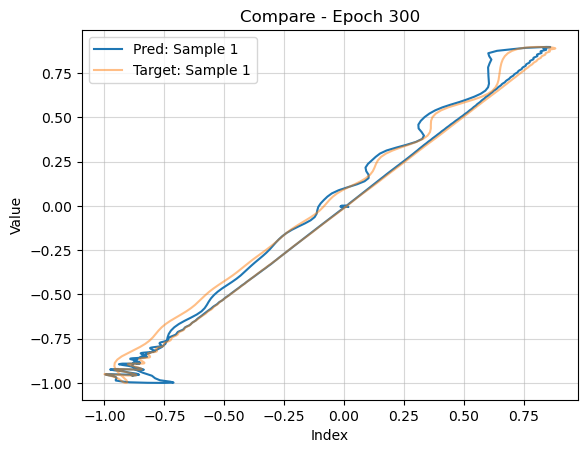

Epoch 301, Train Loss: 0.000662, Validation Loss: 0.000828
Epoch 302, Train Loss: 0.000705, Validation Loss: 0.000725
Epoch 303, Train Loss: 0.000683, Validation Loss: 0.000717
Saving model at epoch 303 with validation loss 0.000717...
Epoch 304, Train Loss: 0.000676, Validation Loss: 0.000720
Epoch 305, Train Loss: 0.000647, Validation Loss: 0.000707
Saving model at epoch 305 with validation loss 0.000707...
Epoch 306, Train Loss: 0.000654, Validation Loss: 0.000705
Saving model at epoch 306 with validation loss 0.000705...
Epoch 307, Train Loss: 0.000652, Validation Loss: 0.000728
Epoch 308, Train Loss: 0.000651, Validation Loss: 0.000753
Epoch 309, Train Loss: 0.000667, Validation Loss: 0.000735
Epoch 310, Train Loss: 0.000715, Validation Loss: 0.000711
Epoch 311, Train Loss: 0.000641, Validation Loss: 0.000712
Epoch 312, Train Loss: 0.000638, Validation Loss: 0.000794
Epoch 313, Train Loss: 0.000676, Validation Loss: 0.000771
Epoch 314, Train Loss: 0.000656, Validation Loss: 0.0007

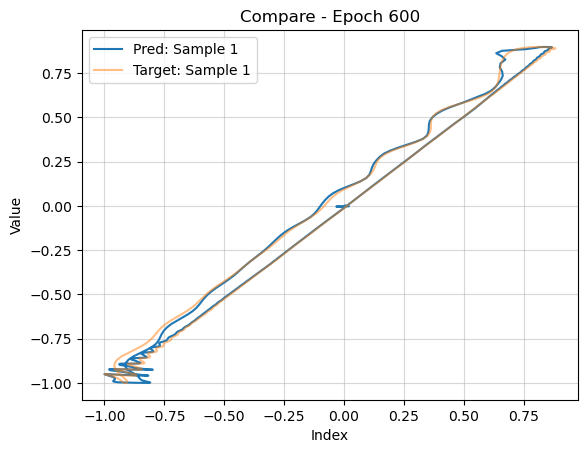

Epoch 601, Train Loss: 0.000556, Validation Loss: 0.000663
Epoch 602, Train Loss: 0.000592, Validation Loss: 0.000616
Epoch 603, Train Loss: 0.000570, Validation Loss: 0.000840
Epoch 604, Train Loss: 0.000661, Validation Loss: 0.000615
Epoch 605, Train Loss: 0.000628, Validation Loss: 0.000625
Epoch 606, Train Loss: 0.000568, Validation Loss: 0.000622
Epoch 607, Train Loss: 0.000552, Validation Loss: 0.000646
Epoch 608, Train Loss: 0.000552, Validation Loss: 0.000615
Epoch 609, Train Loss: 0.000583, Validation Loss: 0.000610
Epoch 610, Train Loss: 0.000562, Validation Loss: 0.000608
Epoch 611, Train Loss: 0.000556, Validation Loss: 0.000646
Epoch 612, Train Loss: 0.000563, Validation Loss: 0.000613
Epoch 613, Train Loss: 0.000534, Validation Loss: 0.000593
Epoch 614, Train Loss: 0.000548, Validation Loss: 0.000704
Epoch 615, Train Loss: 0.000592, Validation Loss: 0.000630
Epoch 616, Train Loss: 0.000603, Validation Loss: 0.000743
Epoch 617, Train Loss: 0.000656, Validation Loss: 0.0006

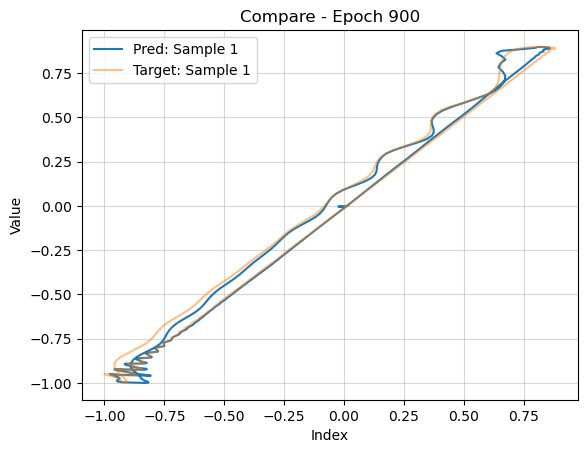

Epoch 901, Train Loss: 0.000535, Validation Loss: 0.000607
Epoch 902, Train Loss: 0.000542, Validation Loss: 0.000584
Epoch 903, Train Loss: 0.000523, Validation Loss: 0.000573
Epoch 904, Train Loss: 0.000524, Validation Loss: 0.000551
Epoch 905, Train Loss: 0.000529, Validation Loss: 0.000587
Epoch 906, Train Loss: 0.000530, Validation Loss: 0.000555
Epoch 907, Train Loss: 0.000520, Validation Loss: 0.000688
Epoch 908, Train Loss: 0.000584, Validation Loss: 0.000622
Epoch 909, Train Loss: 0.000533, Validation Loss: 0.000615
Epoch 910, Train Loss: 0.000509, Validation Loss: 0.000626
Epoch 911, Train Loss: 0.000552, Validation Loss: 0.000661
Epoch 912, Train Loss: 0.000549, Validation Loss: 0.000645
Epoch 913, Train Loss: 0.000532, Validation Loss: 0.000614
Epoch 914, Train Loss: 0.000536, Validation Loss: 0.000608
Epoch 915, Train Loss: 0.000568, Validation Loss: 0.000585
Epoch 916, Train Loss: 0.000521, Validation Loss: 0.000603
Epoch 917, Train Loss: 0.000510, Validation Loss: 0.0006

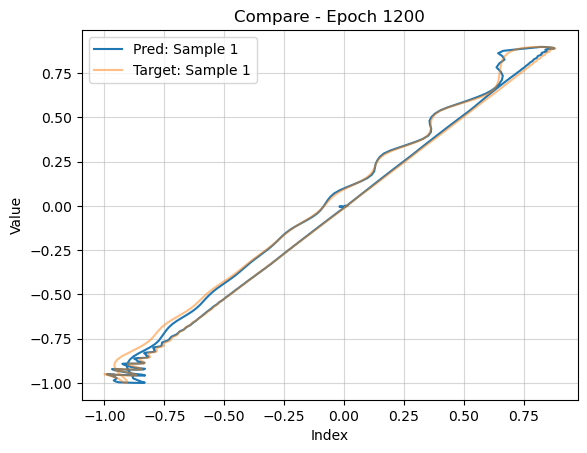

Epoch 1201, Train Loss: 0.000474, Validation Loss: 0.000560
Epoch 1202, Train Loss: 0.000499, Validation Loss: 0.000533
Epoch 1203, Train Loss: 0.000510, Validation Loss: 0.000559
Epoch 1204, Train Loss: 0.000502, Validation Loss: 0.000524
Epoch 1205, Train Loss: 0.000480, Validation Loss: 0.000526
Epoch 1206, Train Loss: 0.000490, Validation Loss: 0.000555
Epoch 1207, Train Loss: 0.000505, Validation Loss: 0.000594
Epoch 1208, Train Loss: 0.000545, Validation Loss: 0.000575
Epoch 1209, Train Loss: 0.000548, Validation Loss: 0.000643
Epoch 1210, Train Loss: 0.000517, Validation Loss: 0.000535
Epoch 1211, Train Loss: 0.000509, Validation Loss: 0.000543
Epoch 1212, Train Loss: 0.000494, Validation Loss: 0.000603
Epoch 1213, Train Loss: 0.000485, Validation Loss: 0.000531
Epoch 1214, Train Loss: 0.000502, Validation Loss: 0.000560
Epoch 1215, Train Loss: 0.000514, Validation Loss: 0.000550
Epoch 1216, Train Loss: 0.000508, Validation Loss: 0.000526
Epoch 1217, Train Loss: 0.000493, Valida

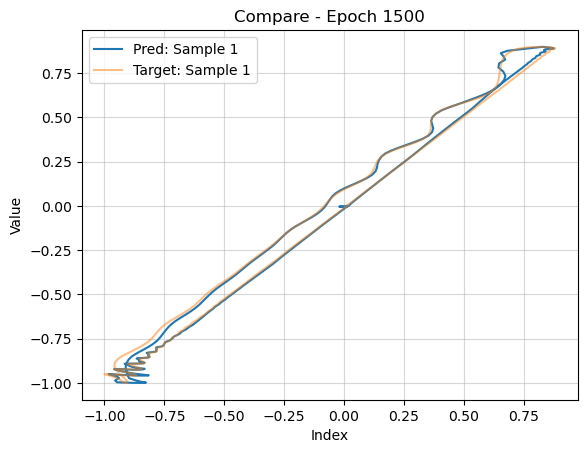

Epoch 1501, Train Loss: 0.000471, Validation Loss: 0.000605
Epoch 1502, Train Loss: 0.000528, Validation Loss: 0.000558
Epoch 1503, Train Loss: 0.000490, Validation Loss: 0.000564
Epoch 1504, Train Loss: 0.000501, Validation Loss: 0.000663
Epoch 1505, Train Loss: 0.000540, Validation Loss: 0.000528
Epoch 1506, Train Loss: 0.000471, Validation Loss: 0.000533
Epoch 1507, Train Loss: 0.000457, Validation Loss: 0.000593
Epoch 1508, Train Loss: 0.000495, Validation Loss: 0.000525
Epoch 1509, Train Loss: 0.000484, Validation Loss: 0.000523
Epoch 1510, Train Loss: 0.000475, Validation Loss: 0.000514
Epoch 1511, Train Loss: 0.000479, Validation Loss: 0.000524
Epoch 1512, Train Loss: 0.000465, Validation Loss: 0.000568
Epoch 1513, Train Loss: 0.000491, Validation Loss: 0.000598
Epoch 1514, Train Loss: 0.000487, Validation Loss: 0.000516
Epoch 1515, Train Loss: 0.000499, Validation Loss: 0.000613
Epoch 1516, Train Loss: 0.000504, Validation Loss: 0.000535
Epoch 1517, Train Loss: 0.000477, Valida

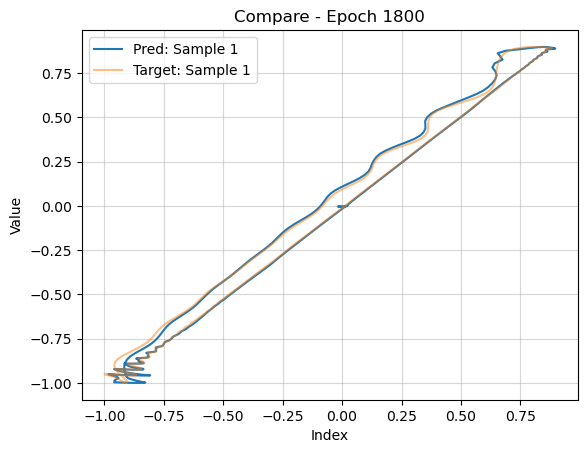

Epoch 1801, Train Loss: 0.000490, Validation Loss: 0.000508
Epoch 1802, Train Loss: 0.000478, Validation Loss: 0.000581
Epoch 1803, Train Loss: 0.000484, Validation Loss: 0.000518
Epoch 1804, Train Loss: 0.000473, Validation Loss: 0.000534
Epoch 1805, Train Loss: 0.000520, Validation Loss: 0.000638
Epoch 1806, Train Loss: 0.000546, Validation Loss: 0.000558
Epoch 1807, Train Loss: 0.000467, Validation Loss: 0.000496
Saving model at epoch 1807 with validation loss 0.000496...
Epoch 1808, Train Loss: 0.000485, Validation Loss: 0.000567
Epoch 1809, Train Loss: 0.000486, Validation Loss: 0.000525
Epoch 1810, Train Loss: 0.000495, Validation Loss: 0.000626
Epoch 1811, Train Loss: 0.000538, Validation Loss: 0.000640
Epoch 1812, Train Loss: 0.000476, Validation Loss: 0.000527
Epoch 1813, Train Loss: 0.000475, Validation Loss: 0.000510
Epoch 1814, Train Loss: 0.000471, Validation Loss: 0.000529
Epoch 1815, Train Loss: 0.000485, Validation Loss: 0.000521
Epoch 1816, Train Loss: 0.000458, Valida

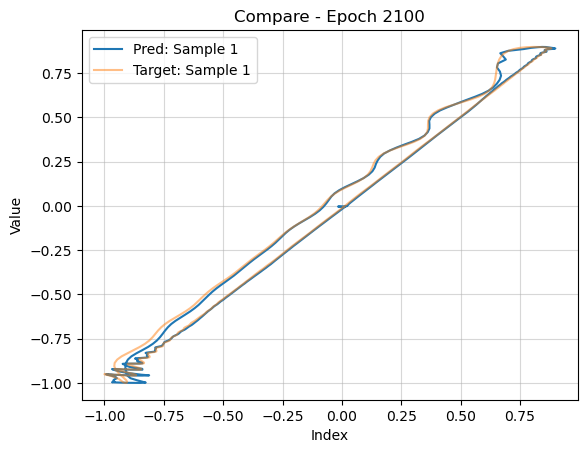

Epoch 2101, Train Loss: 0.000482, Validation Loss: 0.000739
Epoch 2102, Train Loss: 0.000527, Validation Loss: 0.000530
Epoch 2103, Train Loss: 0.000501, Validation Loss: 0.000517
Epoch 2104, Train Loss: 0.000462, Validation Loss: 0.000536
Epoch 2105, Train Loss: 0.000481, Validation Loss: 0.000562
Epoch 2106, Train Loss: 0.000464, Validation Loss: 0.000508
Epoch 2107, Train Loss: 0.000468, Validation Loss: 0.000534
Epoch 2108, Train Loss: 0.000469, Validation Loss: 0.000549
Epoch 2109, Train Loss: 0.000465, Validation Loss: 0.000518
Epoch 2110, Train Loss: 0.000460, Validation Loss: 0.000508
Epoch 2111, Train Loss: 0.000456, Validation Loss: 0.000512
Epoch 2112, Train Loss: 0.000469, Validation Loss: 0.000519
Epoch 2113, Train Loss: 0.000482, Validation Loss: 0.000510
Epoch 2114, Train Loss: 0.000444, Validation Loss: 0.000552
Epoch 2115, Train Loss: 0.000475, Validation Loss: 0.000532
Epoch 2116, Train Loss: 0.000472, Validation Loss: 0.000594
Epoch 2117, Train Loss: 0.000475, Valida

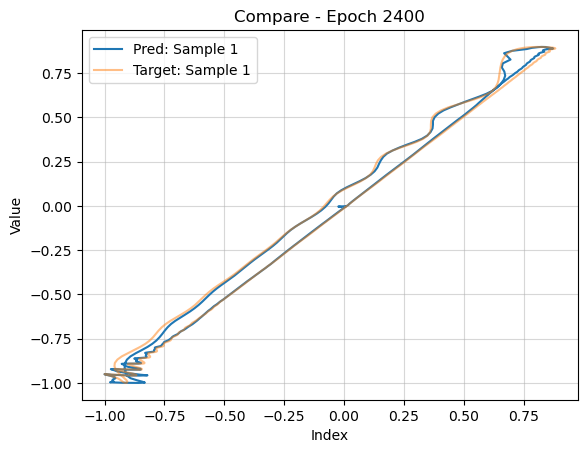

Epoch 2401, Train Loss: 0.000461, Validation Loss: 0.000523
Epoch 2402, Train Loss: 0.000454, Validation Loss: 0.000579
Epoch 2403, Train Loss: 0.000493, Validation Loss: 0.000509
Epoch 2404, Train Loss: 0.000480, Validation Loss: 0.000516
Epoch 2405, Train Loss: 0.000447, Validation Loss: 0.000617
Epoch 2406, Train Loss: 0.000478, Validation Loss: 0.000619
Epoch 2407, Train Loss: 0.000479, Validation Loss: 0.000505
Epoch 2408, Train Loss: 0.000464, Validation Loss: 0.000579
Epoch 2409, Train Loss: 0.000474, Validation Loss: 0.000496
Epoch 2410, Train Loss: 0.000437, Validation Loss: 0.000508
Epoch 2411, Train Loss: 0.000451, Validation Loss: 0.000515
Epoch 2412, Train Loss: 0.000443, Validation Loss: 0.000527
Epoch 2413, Train Loss: 0.000476, Validation Loss: 0.000522
Epoch 2414, Train Loss: 0.000475, Validation Loss: 0.000799
Epoch 2415, Train Loss: 0.000528, Validation Loss: 0.000514
Epoch 2416, Train Loss: 0.000522, Validation Loss: 0.000588
Epoch 2417, Train Loss: 0.000471, Valida

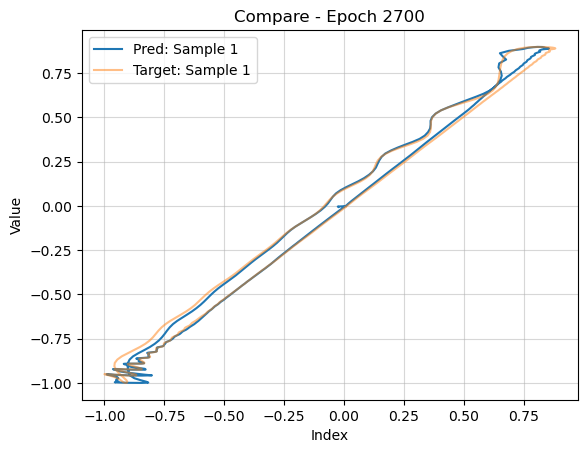

Epoch 2701, Train Loss: 0.000455, Validation Loss: 0.000490
Epoch 2702, Train Loss: 0.000431, Validation Loss: 0.000480
Saving model at epoch 2702 with validation loss 0.000480...
Epoch 2703, Train Loss: 0.000473, Validation Loss: 0.000531
Epoch 2704, Train Loss: 0.000487, Validation Loss: 0.000617
Epoch 2705, Train Loss: 0.000496, Validation Loss: 0.000504
Epoch 2706, Train Loss: 0.000457, Validation Loss: 0.000489
Epoch 2707, Train Loss: 0.000455, Validation Loss: 0.000523
Epoch 2708, Train Loss: 0.000482, Validation Loss: 0.000490
Epoch 2709, Train Loss: 0.000500, Validation Loss: 0.000529
Epoch 2710, Train Loss: 0.000453, Validation Loss: 0.000529
Epoch 2711, Train Loss: 0.000486, Validation Loss: 0.000514
Epoch 2712, Train Loss: 0.000454, Validation Loss: 0.000514
Epoch 2713, Train Loss: 0.000472, Validation Loss: 0.000730
Epoch 2714, Train Loss: 0.000538, Validation Loss: 0.000606
Epoch 2715, Train Loss: 0.000458, Validation Loss: 0.000489
Epoch 2716, Train Loss: 0.000474, Valida

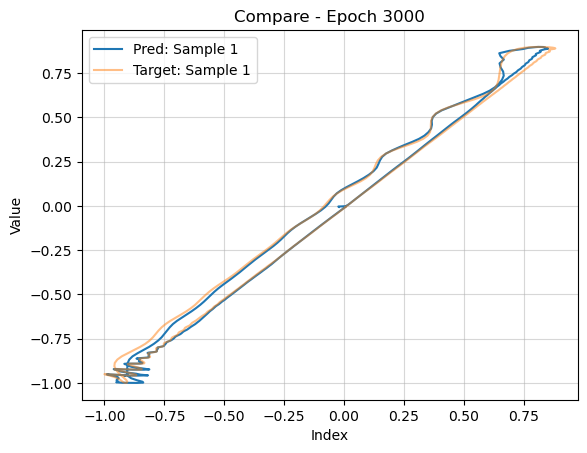

Training complete. Best model saved at ./Model/linspace_n_init2/1024/CH467160_Buck_n_init2.pt.


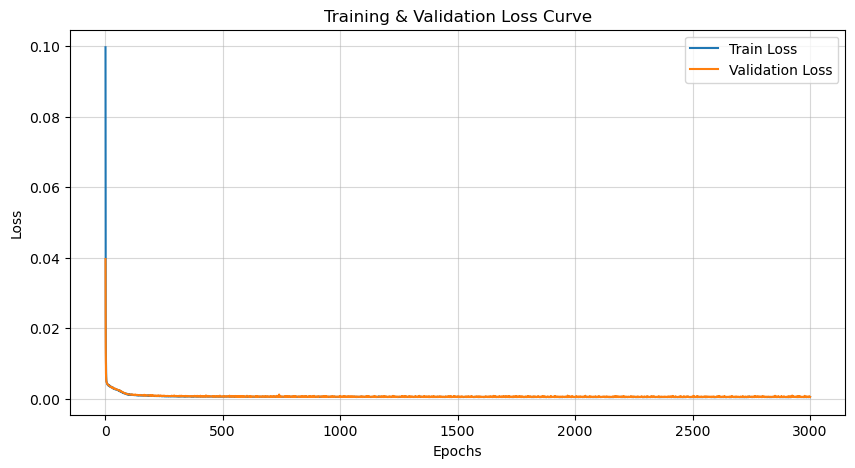

C:\Users\USER\AppData\Local\Temp\ipykernel_58288\1838465554.py:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))  # 載入最佳模

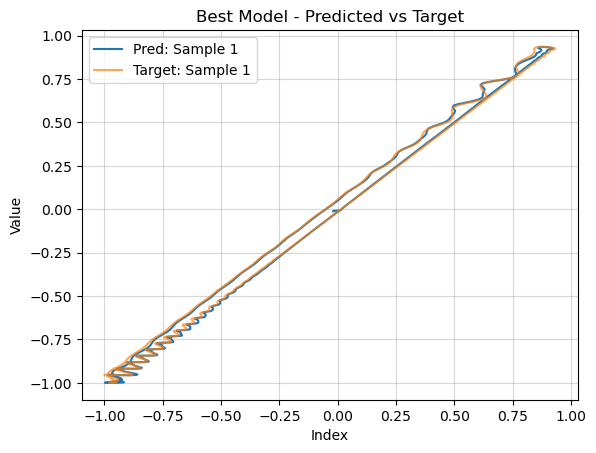

In [112]:
if __name__ == "__main__":

    data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N = load_dataset(
        material)

    train_loader, valid_loader, norm = get_dataloader(data_B, data_F, data_T,
                                                      data_H, data_N, data_Hdc,
                                                      data_Pcv)

# ---- 印第一個 batch 檢查 ----
# inputs, features, s0, target_H, target_Pcv = next(iter(train_loader))
inputs, features, s0, target_H = next(iter(train_loader))

print("=== Batch shape check ===")
print(f"inputs      : {inputs.shape}")  # (batch, seq_len, 4)
print(f"features    : {features.shape}")  # (batch, 4)
print(f"s0          : {s0.shape}")  # (batch, operator_size)
print(f"target_H    : {target_H.shape}")  # (batch, seq_len, 1)
# print(f"target_Pcv  : {target_Pcv.shape}")  # (batch, 1)
print()

# 選一筆樣本看看數值範圍
idx = 0
print("範例 inputs[0] (前 3 個時間點):")
print(inputs[idx, :3, :])  # B, ΔB, dB/dt, d²B/dt² (已歸一化到 ~[-1,1])
print("範例 features[0]:", features[idx])  # F, T, Hdc, N (已 z-score)
print("範例 s0[0]:", s0[idx, :5])  # 前 5 個 Preisach operator 狀態
print("範例 target_H[0] (前 3 點):", target_H[idx, :3, 0])
# print("範例 target_Pcv[0]:", target_Pcv[idx, 0])

train_model(norm, train_loader, valid_loader)